In [1]:
class SAT_task:
    def __init__(self, task_file = '', var_count: int = 0, clause_count: int = 0, clause_list: list = [], weights: list = [], optimal_conf: list = None, optimal_w = 0):
        self.task_file = task_file
        self.var_count = var_count
        self.clause_count = clause_count
        self.clause_list = clause_list
        self.weights = weights
        self.optimal_conf = optimal_conf
        self.optimal_weight = optimal_w
        self.weights_sum = sum(self.weights)
        self.clause_weights = []
        self.clause_weights_sum = 0
        self.clause_weights_to_upgrade = []
        
    def solve(self, configuration: list):
        satisfied_clauses = 0
        weight_sum = 0
        if len(configuration) != self.var_count:
            print(self.var_count, len(configuration))
            raise ValueError('Konfigurace nemá stejnou velikost jako počet proměných')
        
        for i in range(self.var_count):
            if configuration[i] == 1:
                weight_sum += self.weights[i]
        
        for clause in self.clause_list:
            satisfied = False
            for lit in clause:
                neg = False
                if lit < 0:
                    neg = True
                
                val = configuration[abs(lit) - 1]
                if (neg and val == 0) or ((not neg) and val == 1):
                    satisfied = True
                    break
            
            if satisfied:
                satisfied_clauses += 1
                
        return (satisfied_clauses == self.clause_count), satisfied_clauses, weight_sum
    
    def solve_get_clauses(self, configuration: list):
        satisfied_clauses = 0
        weight_sum = 0
        unsolved_clauses = []
        solved_clauses = []
        if len(configuration) != self.var_count:
            print(self.var_count, len(configuration))
            raise ValueError('Konfigurace nemá stejnou velikost jako počet proměných')
        
        for i in range(self.var_count):
            if configuration[i] == 1:
                weight_sum += self.weights[i]
         
        clause_num = 0
        for clause in self.clause_list:
            satisfied = False
            for lit in clause:
                neg = False
                if lit < 0:
                    neg = True
                
                val = configuration[abs(lit) - 1]
                if (neg and val == 0) or ((not neg) and val == 1):
                    satisfied = True
                    break
            
            
            if satisfied:
                satisfied_clauses += 1
                solved_clauses.append(clause_num)
            else:
                unsolved_clauses.append(clause_num)
                
            clause_num += 1
            
        return (satisfied_clauses == self.clause_count), satisfied_clauses, weight_sum, solved_clauses, unsolved_clauses
    
    def load_optimal_conf(self, file_name = None):
        if not file_name:
            file_name = self.task_file.replace('.mwcnf', '.opt')
        
        f = open(file_name)
        f_str = f.read()
        lines = f_str.split('\n')
        
        if lines[0] != 'optimum' or lines[2] != 'assignment':
            raise ValueError('Chybný formát souboru s řešením')
        self.optimal_weight = int(lines[1])
        
        conf = lines[3].split(" ")
        if conf[len(conf)-1] == '':
            conf.pop(len(conf)-1)
        for i in range(len(conf)):
            conf[i] = int(conf[i])
        self.optimal_conf = conf
        
    def __str__(self):
        return self.task_file
    
    def upgrade_clause_weights(self, k: float):
        for i in range(self.clause_count):
            self.clause_weights[i] += self.clause_weights_to_upgrade[i] * k
        
    def decrease_clause_weights(self, k: float):
        for i in range(self.clause_count):
            self.clause_weights[i] = max(1, (self.clause_weights[i] - k))

In [2]:
def read_sat_task(file_name: str, A_format = False):
    clause_count = 0
    var_count = 0
    w_list = []
    clause_list = []
    
    f = open(file_name)
    f_str = f.read()
    lines = f_str.split('\n')
    for line in lines:
        if line[0] == 'c':
            continue
        elif line[0] == 'p':
            if line[2:7] == 'mwcnf':
                split_line = line.split(" ")
                var_count = int(split_line[2])
                clause_count = int(split_line[3])
            else:
                raise ValueError('SAT task file nemá mwcnf formát!')
        elif line[0] == 'w':
            if not A_format:
                split_line = line.split(" ")
            else:
                split_line = line.split(" ")
                split_line = list(filter(('').__ne__, split_line))
            if split_line[len(split_line) - 1] != '0' or split_line[0] != 'w':
                raise ValueError('řádek s váhami nemá správný formát')
            w_list = split_line[1:-1]
            for i in range(len(w_list)):
                w_list[i] = int(w_list[i])
        elif line[0] == '%':
            break
        else:
            if line[0] == ' ':
                line = line[1:]
            end = len(line) - 1
            if line[end] != '0':
                print(file_name)
                print(line)
                raise ValueError('Klausule nekončí 0')
            clause = []
            for lit in (line.split(" "))[0:-1]:
                clause.append(int(lit))

            clause_list.append(clause)
            
    sat_task = SAT_task(file_name, var_count, clause_count, clause_list, w_list, None)
    return sat_task
        

In [3]:
from os import listdir
from os.path import isfile, join
import copy

sat_tasks = dict()
"""
M_20_78 M_50_201 M_75_310
N_20_78 N_50_201 N_75_310
Q_20_78 Q_50_201 Q_75_310
R_20_78 R_50_201 R_75_310
A_20_80 A_20_91 A_100_430
"""

datasets = ['M', 'N', 'R', 'Q']
variables = [20, 50, 75]
clauses = [78, 201, 310]

for dataset in datasets:
    for i in range(len(variables)):
        key = dataset + "_" + str(variables[i]) + "_" + str(clauses[i])
        sat_tasks[key] = []
        dir_path = './data/wuf-' + dataset +'/wuf' +  str(variables[i]) + '-' + str(clauses[i]) + '-' + dataset + '/'
        file_nums = range(1, 51)
        for j in file_nums:
            file_name = 'wuf' + str(variables[i]) + '-0' + str(j) + '.mwcnf'
            file_path = dir_path + file_name
            sat_task = read_sat_task(file_path)
            sat_task.load_optimal_conf()
            sat_tasks[key].append(sat_task)
            
variables_a = [20, 20, 100]
clauses_a = [88, 91, 430]

for i in range(len(variables_a)):
    dir_path = './data/wuf-A/wuf' +  str(variables_a[i]) + '-' + str(clauses_a[i]) + '-A' + '/'
    key = "A_" + str(variables_a[i]) + "_" + str(clauses_a[i])
    sat_tasks[key] = []
    only_files = [f for f in listdir(dir_path) if isfile(join(dir_path, f))]
    
    for j in range(0,50):
        if '.opt' in only_files[j]:
            continue
        sat_task = read_sat_task(dir_path + only_files[j], True)
        sat_tasks[key].append(copy.deepcopy(sat_task))
        if len(sat_tasks[key]) >= 50:
            break
            

In [4]:
import random
from math import floor
import numpy as np
import matplotlib.pyplot as plt

def random_population(n: int, population_size: int):
    population = []
    for i in range(0, population_size):
        genome = []
        for j in range(0, n):
            gene = random.randint(0,1)
            genome.append(gene)
        population.append(genome)
    return population

def calculate_fitness(genome: list, task: SAT_task, k: float, bonus: float) -> float:
    satisfied, satisfied_clauses, w_sum = task.solve(genome)
    norm_w = w_sum / task.weights_sum
    norm_sc = satisfied_clauses / task.clause_count
    f = (norm_sc * k) + norm_w
    if satisfied:
        f = f + bonus
    return f
             
def calculate_scores(population: list, task: SAT_task, k: float, bonus: float) -> list:
    scores = []
    i = 0
    for genome in population:
        f = calculate_fitness(genome, task, k, bonus)
        population[i] = genome
        scores.append(f)
        i += 1
    return scores

def select_from_population(population: list, scores: list, selection_size: int):
    selected = []
    selected_scores = []
    for i in range(0, selection_size):
        luckyone = roulette_selection(population, scores)
        selected.append(luckyone)
        selected_scores.append(scores[i])
    return selected, selected_scores

def roulette_selection(population, scores):
    scoresum = sum(scores)
    rng = random.uniform(0, scoresum)
    i = 0
    n = 0
    for score in scores:
        n = n + score
        if n > rng or i == len(scores) - 1:
            break
        i = i+ 1
    return population[i]

def uniform_crossover(chromosome1: list, chromosome2: list, n: int) -> list:
    new_chromosome = []
    for i in range(0, n):
        rng = random.randint(0,1)
        if rng == 0:
            new_chromosome.append(chromosome1[i])
        elif rng == 1:
            new_chromosome.append(chromosome2[i])
    return new_chromosome

def one_point_crossover(chromozome1: list ,chromozome2: list, n: int) -> list:
    new_chromozome = []
    rng = random.randint(0, n)
    for i in range(0, rng):
        new_chromozome.append(chromozome1[i])
    for i in range(rng, n):
        new_chromozome.append(chromozome2[i])
    return  new_chromozome

def mutate(chromozome: list, mutation_rate: float):
    for i in range(0,len(chromozome)):
        rng = random.uniform(0,1)
        if rng < mutation_rate:
            chromozome[i] = 1 - chromozome[i]

def choose_best(population: list, scores: list, task: SAT_task) -> tuple:
    max_satisfied_clauses = None
    max_w = None
    best_conf = None
    
    for genome in population:
        satisfied, satisfied_clauses, w_sum = task.solve(genome)
        if max_satisfied_clauses == None:
            max_satisfied_clauses = satisfied_clauses
            max_w = w_sum
            best_conf = genome
        else:
            if satisfied_clauses > max_satisfied_clauses:
                max_satisfied_clauses = satisfied_clauses
                max_w = w_sum
                best_conf = genome
            elif satisfied_clauses == max_satisfied_clauses:
                if max_w < w_sum:
                    max_w = w_sum
                    best_conf = genome
        
    return best_conf, max_satisfied_clauses, max_w

def sat_solver_genetic(task: SAT_task, params: dict):
    max_generations = params['max_generations']
    mutation_prob = params['mutation_prob']
    crossover_prob = params['crossover_prob']
    crossover = params['crossover']
    create_graph = params['create_graph']
    title = params['title']
    pop_multiplifier = params['pop_multiplifier']
    fit_k = params['fit_k']
    fit_bonus = params['fit_bonus']
    sel_size = params['sel_size']
    
    c_count = task.clause_count
    v_count = task.var_count
    pop_size = v_count * pop_multiplifier
    select_size = floor(pop_size * sel_size)
    population = random_population(v_count, pop_size)
    scores = calculate_scores(population, task, fit_k, fit_bonus)
    
    max_satisfied_clauses = -1
    best_genome = None
    max_w_sum = -1
    recent_best = 0
    passive_cycles = 0
    
    if create_graph:
        f_mins = []
        f_maxs = []
        f_avgs = []
        c_sat = []
        w_sums = []
    
    for i in range(1, max_generations+1):
        #print("Generation num:", i)
        selected, selected_scores = select_from_population(population, scores, select_size)
        next_gen = []
        for j in range(pop_size):
            rng = random.uniform(0,1)
            selected1 = roulette_selection(selected, selected_scores)
            if rng > crossover_prob:
                new_chromozome = selected1
            else:
                selected2 = roulette_selection(selected, selected_scores)
                if crossover == 'uniform':
                    new_chromozome = uniform_crossover(selected1, selected2, v_count)
                elif crossover == 'onepoint':
                    new_chromozome = one_point_crossover(selected1, selected2, v_count)
            mutate(new_chromozome, mutation_prob)
            next_gen.append(new_chromozome)

            
        population = next_gen
        scores = calculate_scores(population, task, fit_k, fit_bonus)
        best_conf, satisfied_clauses, w_sum = choose_best(population, scores, task)
        
        best_f = max(scores)
        avg_f = sum(scores)/ len(scores)
        min_f = min(scores)
        if create_graph:
            f_mins.append(min_f)
            f_maxs.append(best_f)
            f_avgs.append(avg_f)
            c_sat.append(satisfied_clauses)
            w_sums.append(w_sum)
            
        if (satisfied_clauses > max_satisfied_clauses) or ((satisfied_clauses == max_satisfied_clauses) and (w_sum > max_w_sum)):
            max_w_sum = w_sum
            max_satisfied_clauses = satisfied_clauses
            best_genome = best_conf
        
        k = (abs(recent_best - best_f) / best_f) * 100
        if k < 0.5:
            passive_cycles += 1
        else:
            passive_cycles = 0
            
        if passive_cycles > 100:
            break
        
        if best_f > recent_best:
            recent_best = best_f
    
    if create_graph:
        plt.figure(figsize=(12, 4))
        plt.suptitle(title)

        generations = range(1, len(f_maxs) + 1)
        
        plt.subplot(131)
        plt.plot(generations, f_maxs, label='max')
        plt.plot(generations, f_avgs, label='avg')
        plt.plot(generations, f_mins, label='min')
        plt.xlabel('generation')
        plt.ylabel('fitness')
        plt.legend()
        
        plt.subplot(132)
        plt.plot(generations, c_sat)
        plt.xlabel('generation')
        plt.ylabel('max satisfied clauses')
        plt.legend()
        
        plt.subplot(133)
        plt.plot(generations, w_sums)
        plt.xlabel('generation')
        plt.ylabel('max w sum')
        plt.legend()
        plt.tight_layout()
        plt.show()
    
    return best_genome, max_satisfied_clauses, max_w_sum

In [5]:
def calculate_fitness_upg(genome: list, task: SAT_task, k: float, bonus: float) -> float:
    satisfied, satisfied_clauses, w_sum, solved_clauses, unsolved_clauses = task.solve_get_clauses(genome)
    norm_w = w_sum / task.weights_sum
    sc = 0
    for clause in solved_clauses:
        sc += (task.clause_weights[clause])
    norm_sc = sc / task.clause_weights_sum
    f = (norm_sc * k) + norm_w
    if satisfied:
        f = f + bonus
    for uclause in unsolved_clauses:
        task.clause_weights_to_upgrade[uclause] += 1
    return f
             
def calculate_scores_upg(population: list, task: SAT_task, k: float, bonus: float) -> list:
    scores = []
    i = 0
    for genome in population:
        f = calculate_fitness_upg(genome, task, k, bonus)
        population[i] = genome
        scores.append(f)
        i += 1
    return scores

def mutate_upg(chromozome: list, mutation_rate: float, p_greed: float, p_reset: float, task: SAT_task):
    rng = random.uniform(0,1)
    if rng < p_reset:
        for i in range(len(chromozome)): 
            gene = random.randint(0,1)
            chromozome[i] = gene
    else:
        for i in range(0,len(chromozome)):
            rng = random.uniform(0,1)
            if rng < mutation_rate:
                rng = random.uniform(0,1)
                if rng < p_greed:
                    oposite = chromozome.copy()
                    oposite[i] = 1 - chromozome[i]
                    satisfied1, satisfied_clauses1, w_sum1 = task.solve(chromozome)
                    satisfied2, satisfied_clauses2, w_sum2 = task.solve(oposite)
                    if satisfied_clauses1 < satisfied_clauses2:
                        chromozome = oposite
                    elif satisfied_clauses1 == satisfied_clauses2:
                        if w_sum2 > w_sum1:
                            chromozome = oposite
                        
                else:
                    chromozome[i] = 1 - chromozome[i]
                    
                    

def sat_solver_genetic_upg(task: SAT_task, params: dict):
    max_generations = params['max_generations']
    mutation_prob = params['mutation_prob']
    crossover_prob = params['crossover_prob']
    crossover = params['crossover']
    create_graph = params['create_graph']
    title = params['title']
    pop_multiplifier = params['pop_multiplifier']
    fit_k = params['fit_k']
    fit_bonus = params['fit_bonus']
    sel_size = params['sel_size']
    mut_upg = params['mut_upg']
    mut_p_greed = params['mut_p_greed']
    mut_p_reset = params['mut_p_reset']
    fit_upg = params['fit_upg']
    fit_upg_add_k = params['fit_upg_add_k'] / task.var_count
    fit_upg_dec_k = params['fit_upg_dec_k']
    
    if fit_upg:
        task.clause_weights = []
        for i in range(task.clause_count):
            task.clause_weights.append(1)
        task.clause_weights_to_upgrade = [0] * task.clause_count
        task.clause_weights_sum = sum(task.clause_weights)
    
    c_count = task.clause_count
    v_count = task.var_count
    pop_size = v_count * pop_multiplifier
    select_size = floor(pop_size * sel_size)
    population = random_population(v_count, pop_size)
    
    if fit_upg:
        scores = calculate_scores_upg(population, task, fit_k, fit_bonus)
    else:
        scores = calculate_scores(population, task, fit_k, fit_bonus)

    max_satisfied_clauses = -1
    best_genome = None
    max_w_sum = -1
    recent_best = 0
    passive_cycles = 0
    
    if create_graph:
        f_mins = []
        f_maxs = []
        f_avgs = []
        c_sat = []
        w_sums = []
    
    for i in range(1, max_generations+1):
        #print("Generation num:", i, 'weights:', task.clause_weights)
        selected, selected_scores = select_from_population(population, scores, select_size)
        next_gen = []
        for j in range(pop_size):
            rng = random.uniform(0,1)
            selected1 = roulette_selection(selected, selected_scores)
            if rng > crossover_prob:
                new_chromozome = selected1
            else:
                selected2 = roulette_selection(selected, selected_scores)
                if crossover == 'uniform':
                    new_chromozome = uniform_crossover(selected1, selected2, v_count)
                elif crossover == 'onepoint':
                    new_chromozome = one_point_crossover(selected1, selected2, v_count)
                    
            if mut_upg:
                mutate_upg(new_chromozome, mutation_prob, mut_p_greed, mut_p_reset, task)
            else:
                mutate(new_chromozome, mutation_prob)
            next_gen.append(new_chromozome)

            
        population = next_gen
        if fit_upg:
            task.clause_weights_to_upgrade = [0] * task.clause_count
            task.clause_weights_sum = sum(task.clause_weights)
            scores = calculate_scores_upg(population, task, fit_k, fit_bonus)
            task.upgrade_clause_weights(fit_upg_add_k)
            task.decrease_clause_weights(fit_upg_dec_k)
        else:
            scores = calculate_scores(population, task, fit_k, fit_bonus)

        
        best_conf, satisfied_clauses, w_sum = choose_best(population, scores, task)
        
        best_f = max(scores)
        avg_f = sum(scores)/ len(scores)
        min_f = min(scores)
        if create_graph:
            f_mins.append(min_f)
            f_maxs.append(best_f)
            f_avgs.append(avg_f)
            c_sat.append(satisfied_clauses)
            w_sums.append(w_sum)
            
        if (satisfied_clauses > max_satisfied_clauses) or ((satisfied_clauses == max_satisfied_clauses) and (w_sum > max_w_sum)):
            max_w_sum = w_sum
            max_satisfied_clauses = satisfied_clauses
            best_genome = best_conf
        
        k = (abs(recent_best - best_f) / best_f) * 100
        if k < 0.5:
            passive_cycles += 1
        else:
            passive_cycles = 0
            
        if passive_cycles > 100:
            break
        
        if best_f > recent_best:
            recent_best = best_f
    
    if create_graph:
        plt.figure(figsize=(12, 4))
        plt.suptitle(title)

        generations = range(1, len(f_maxs) + 1)
        
        plt.subplot(131)
        plt.plot(generations, f_maxs, label='max')
        plt.plot(generations, f_avgs, label='avg')
        plt.plot(generations, f_mins, label='min')
        plt.xlabel('generation')
        plt.ylabel('fitness')
        plt.legend()
        
        plt.subplot(132)
        plt.plot(generations, c_sat)
        plt.xlabel('generation')
        plt.ylabel('max satisfied clauses')
        plt.legend()
        
        plt.subplot(133)
        plt.plot(generations, w_sums)
        plt.xlabel('generation')
        plt.ylabel('max w sum')
        plt.legend()
        plt.tight_layout()
        plt.show()
    
    return best_genome, max_satisfied_clauses, max_w_sum

In [6]:
import re

def export_time(time_str: str) -> float: # Convert time to ms
    i = 0
    val_str = ''
    while re.match('[0-9.]', time_str[i]):
        val_str += time_str[i]
        i += 1
    val = float(val_str)
    
    s_index = time_str.find('s')
    unit = time_str[i+1:s_index+1]
    if unit == 'ns':
        val = val/1000000
    elif unit == 'µs':
        val = val/1000
    elif unit == 's':
        val = val * 1000
    elif unit == 'min':
        val = val * 60 * 1000
    
    return val

def calculate_relative_error(result: float, solution: float) -> float:
    if result == solution:
        return 0
    if solution == 0:
        return 100
    err =  1 - (result / solution)
    return err * 100

In [7]:
from typing import Callable
import timeit

    
def run_sat_solver(sat_tasks: list, repeat_num: int, solver: Callable, genetic_params: dict = None):
    same = 0
    different = 0
    elapsed_time = -1
    time_sum = 0
    max_time = None
    best_time = None
    err_sum = 0
    err_max = 0
    err_min = None
    avg_sat_c = None
    sum_sat_c = 0

    for sat_task in sat_tasks:
        configuration, satisfied_clauses, w_sum = solver(sat_task, genetic_params)
        #elapsed_time =  %timeit -o -n 1 -r 1 solver(sat_task, genetic_params)
        #elapsed_time = export_time(str(elapsed_time))
        elapsed_time = 0
        
        if w_sum == sat_task.optimal_weight and satisfied_clauses == sat_task.clause_count:
            same += 1
        else:
            different += 1
        
        if not max_time:
            max_time = elapsed_time
        else:
            if elapsed_time > max_time:
                max_time = elapsed_time
        if not best_time:
            best_time = elapsed_time
        else:
            if elapsed_time < best_time:
                best_time = elapsed_time
                
        time_sum += elapsed_time
        
        if satisfied_clauses != sat_task.clause_count:
            err = 100
        else:
            err = calculate_relative_error(w_sum, sat_task.optimal_weight)
        
        err_sum += err
        if err > err_max:
            err_max = err
        if not err_min:
            err_min = err
        else:
            if err < err_min:
                err_min = err
                
        sat_c = (satisfied_clauses/sat_task.clause_count)
        sum_sat_c += sat_c
        
    sucess_rate = (same / len(sat_tasks)) * 100
    avg_time = time_sum / len(sat_tasks) 
    err_avg = err_sum / len(sat_tasks)
    avg_sat_c = sum_sat_c / len(sat_tasks)
    
    """
    print('sucess_rate:', sucess_rate)
    print('avg_time:', avg_time)
    print('max_time:', max_time)
    print('best_time:', best_time)
    print('err_avg:', err_avg)
    print('err_max:', err_max)
    print('err_min:', err_min)
    """
    return sucess_rate, avg_time, max_time, best_time, err_avg, err_max, err_min, avg_sat_c

def run_solver_get_values(task_file: str, repeat_num: int, solver: Callable):
    tasks = read_tasks(task_file)
    visited_configs_list = [] 
    i = 0
    for task in tasks:
        i = i+1
        elapsed_time =  %timeit -o -n 5 -r 4 solver(task)
        elapsed_time = export_time(str(elapsed_time))
        visited_configs_list.append(elapsed_time)
        task.reset()
    return visited_configs_list

In [8]:
task = read_sat_task('./data/wuf-Q/wuf75-310-Q/wuf75-01.mwcnf')
task.load_optimal_conf()
x, y, z = task.solve(task.optimal_conf)
print(x)
print(y)
print(z)

True
310
28679


In [9]:
"""
# White box experiment s fitness fcí

params22 = {'max_generations' : 500, 'mutation_prob' : 0.001, 'crossover_prob' : 0.8, 'crossover' : 'onepoint', 'create_graph': True, 'title': 'k=2, bonus=2', 'pop_multiplifier' : 30, 'fit_k': 2, 'fit_bonus': 2}
params42 = {'max_generations' : 500, 'mutation_prob' : 0.001, 'crossover_prob' : 0.8, 'crossover' : 'onepoint', 'create_graph': True, 'title': 'k=4, bonus=2', 'pop_multiplifier' : 30, 'fit_k': 4, 'fit_bonus': 2}
params62 = {'max_generations' : 500, 'mutation_prob' : 0.001, 'crossover_prob' : 0.8, 'crossover' : 'onepoint', 'create_graph': True, 'title': 'k=6, bonus=2', 'pop_multiplifier' : 30, 'fit_k': 6, 'fit_bonus': 2}
params25 = {'max_generations' : 500, 'mutation_prob' : 0.001, 'crossover_prob' : 0.8, 'crossover' : 'onepoint', 'create_graph': True, 'title': 'k=2, bonus=5', 'pop_multiplifier' : 30, 'fit_k': 2, 'fit_bonus': 5}
params45 = {'max_generations' : 500, 'mutation_prob' : 0.001, 'crossover_prob' : 0.8, 'crossover' : 'onepoint', 'create_graph': True, 'title': 'k=4, bonus=5', 'pop_multiplifier' : 30, 'fit_k': 4, 'fit_bonus': 5}
params65 = {'max_generations' : 500, 'mutation_prob' : 0.001, 'crossover_prob' : 0.8, 'crossover' : 'onepoint', 'create_graph': True, 'title': 'k=6, bonus=5', 'pop_multiplifier' : 30, 'fit_k': 6, 'fit_bonus': 5}
params20 = {'max_generations' : 500, 'mutation_prob' : 0.001, 'crossover_prob' : 0.8, 'crossover' : 'onepoint', 'create_graph': True, 'title': 'k=2, bonus=0', 'pop_multiplifier' : 30, 'fit_k': 2, 'fit_bonus': 0}
params40 = {'max_generations' : 500, 'mutation_prob' : 0.001, 'crossover_prob' : 0.8, 'crossover' : 'onepoint', 'create_graph': True, 'title': 'k=4, bonus=0', 'pop_multiplifier' : 30, 'fit_k': 4, 'fit_bonus': 0}
params60 = {'max_generations' : 500, 'mutation_prob' : 0.001, 'crossover_prob' : 0.8, 'crossover' : 'onepoint', 'create_graph': True, 'title': 'k=6, bonus=0', 'pop_multiplifier' : 30, 'fit_k': 6, 'fit_bonus': 0}
print(sat_tasks['N_50_201'][0], sat_tasks['N_50_201'][0].var_count)

#print(sat_solver_genetic((sat_tasks['M_20_78'])[0],params))
i = 0
for param in [params22, params42, params62, params25, params45, params65, params20, params40, params60]:
    i += 1
    print(i)
    run_sat_solver([(sat_tasks['N_50_201'])[0]], 1, sat_solver_genetic, param)
    run_sat_solver([(sat_tasks['N_20_78'][0])], 1, sat_solver_genetic, param)
    
"""

"\n# White box experiment s fitness fcí\n\nparams22 = {'max_generations' : 500, 'mutation_prob' : 0.001, 'crossover_prob' : 0.8, 'crossover' : 'onepoint', 'create_graph': True, 'title': 'k=2, bonus=2', 'pop_multiplifier' : 30, 'fit_k': 2, 'fit_bonus': 2}\nparams42 = {'max_generations' : 500, 'mutation_prob' : 0.001, 'crossover_prob' : 0.8, 'crossover' : 'onepoint', 'create_graph': True, 'title': 'k=4, bonus=2', 'pop_multiplifier' : 30, 'fit_k': 4, 'fit_bonus': 2}\nparams62 = {'max_generations' : 500, 'mutation_prob' : 0.001, 'crossover_prob' : 0.8, 'crossover' : 'onepoint', 'create_graph': True, 'title': 'k=6, bonus=2', 'pop_multiplifier' : 30, 'fit_k': 6, 'fit_bonus': 2}\nparams25 = {'max_generations' : 500, 'mutation_prob' : 0.001, 'crossover_prob' : 0.8, 'crossover' : 'onepoint', 'create_graph': True, 'title': 'k=2, bonus=5', 'pop_multiplifier' : 30, 'fit_k': 2, 'fit_bonus': 5}\nparams45 = {'max_generations' : 500, 'mutation_prob' : 0.001, 'crossover_prob' : 0.8, 'crossover' : 'onep

In [10]:
from tabulate import tabulate

def test_algorithms(create_pop_size_tables: bool = False, create_sel_size_tables:bool = False, create_black_box_tables: bool = False,\
                    test_basic_genetic: bool = False, test_upg_fitness: bool = False, test_upg_mut: bool = False, test_upg_alg: bool = False,\
                    test_iterative_power: bool = False):

    avg_list = []
    sat_tasks_files = [sat_tasks['N_20_78'][0:5], sat_tasks['N_50_201'][0:5], sat_tasks['N_75_310'][0:5]]
    sat_tasks_str = ['wuf20-78-N', 'wuf50-201-N', 'wuf75-310-N']
    
    if create_pop_size_tables:
        k = [5, 15, 30, 50]
        table = []
        for i in range(0, 3):
            tasks = sat_tasks_files[i]
            results = []
            for j in range(len(k)):
                params = {'max_generations' : 200, 'mutation_prob' : 0.001, 'crossover_prob' : 0.8, 'crossover' : 'onepoint', 'create_graph': False, 'title': '', 'pop_multiplifier' : k[j], 'sel_size' : 0.125, 'fit_k': 3, 'fit_bonus': 2}
                acc, avgt, maxt, mint, avge, maxe, mine = run_sat_solver(tasks, 1, sat_solver_genetic, params)
                result = str(round((avgt/1000), 1)) + '/' + str(round(avge, 1))
                results.append(result)
            table.append([sat_tasks_str[i], results[0], results[1], results[2], results[3]])
            with open('table_pop_size.txt', 'a', encoding="utf-8") as f:
                    f.write('Population size' +'\n')
                    f.write(tabulate(table, headers = ["dataset", 'pop=n*5', 'pop=n*15', 'pop=n*30', 'pop=n*50'], tablefmt = 'fancy_grid') + '\n')
   
    if create_sel_size_tables:
        s = [0.35, 0.25, 0.125, 0.05]
        table = []
        for i in range(0, 3):
            tasks = sat_tasks_files[i]
            results = []
            for j in range(len(s)):
                params = {'max_generations' : 200, 'mutation_prob' : 0.001, 'crossover_prob' : 0.8, 'crossover' : 'onepoint', 'create_graph': False, 'title': '', 'pop_multiplifier' : 30, 'sel_size' : s[j], 'fit_k': 3, 'fit_bonus': 2}
                acc, avgt, maxt, mint, avge, maxe, mine = run_sat_solver(tasks, 1, sat_solver_genetic, params)
                result = str(round((avgt/1000), 1)) + '/' + str(round(avge, 1))
                results.append(result)
            table.append([sat_tasks_str[i], results[0], results[1], results[2], results[3]])
            with open('table_sel_size.txt', 'a', encoding="utf-8") as f:
                    f.write('Selection size' +'\n')
                    f.write(tabulate(table, headers = ["dataset", 's_size=0.35', 's_size=0.25', 's_size=0.125', 's_size=0.05'], tablefmt = 'fancy_grid') + '\n')
   

    if create_black_box_tables:
        table = []
        n_list = [30, 33, 36, 39, 42, 45, 48, 51]
        for n in n_list:
            task_file = ('./files/bb' + str(n) + '.dat') 
            sol_file = ('./files/bb' + str(n) + '_sol.dat')
            params = {'generation_count' : 100, 'mutation_prob' : 0.001, 'crossover_prob' : 0.8, 'crossover' : 'onepoint', 'create_graph': False, 'title': '', 'pop_k' : 30}
            acc, avgt, maxt, avge, maxe = run_solver(task_file, 1, knapsack_solver_genetic_algorithm, sol_file, genetic_params=params)
            table.append([str(n), str(round(avgt/1000, 1)), str(round(maxt/1000, 1)), str(round(avge, 1)), str(round(maxe, 1))])
            with open('table_blackbox.txt', 'a', encoding="utf-8") as f:
                    f.write('Black box experiment results' +'\n')
                    f.write(tabulate(table, headers = ["n", 'avg t', 'max t', 'avg e', 'max e'], tablefmt = 'fancy_grid') + '\n')


    if test_basic_genetic:
        table_t = []
        table_e = []
        params = {'max_generations' : 1000, 'mutation_prob' : 0.001, 'crossover_prob' : 0.95, 'crossover' : 'uniform', 'create_graph': False, 'title': '', 'pop_multiplifier' : 30, 'sel_size' : 0.18, 'fit_k': 3, 'fit_bonus': 2}
        datasets = [sat_tasks['M_20_78'][0:10], sat_tasks['N_20_78'][0:10], sat_tasks['Q_20_78'][0:10], sat_tasks['R_20_78'][0:10],\
                    sat_tasks['A_20_88'][0:8], sat_tasks['A_20_91'][0:6], sat_tasks['M_50_201'][0:5], sat_tasks['N_50_201'][0:5],\
                    sat_tasks['Q_50_201'][0:5], sat_tasks['R_50_201'][0:5], sat_tasks['M_75_310'][0:3], sat_tasks['N_75_310'][0:3],\
                    sat_tasks['Q_75_310'][0:3], sat_tasks['R_75_310'][0:3], sat_tasks['A_100_430'][0:3]]
        datasets_str = ['wuf20-78-M', 'wuf20-78-N', 'wuf20-78-Q', 'wuf20-78-R', 'wuf20-80-A', 'wuf20-91-A', 'wuf50-201-M', 'wuf50-201-N', 'wuf50-201-Q', 'wuf50-201-R', 'wuf75-310-M', 'wuf75-310-N', 'wuf75-310-Q', 'wuf75-310-R', 'wuf100-430-A']
        for i in range(0, 15):
            data = datasets[i]
            acc, avgt, maxt, mint, avge, maxe, mine, sat_c = run_sat_solver(data, 1, sat_solver_genetic, params)
            table_t.append([datasets_str[i], str(round(avgt/1000, 1)), str(round(maxt/1000, 1)), str(round(mint/1000, 1))])
            table_e.append([datasets_str[i], str(round(avge, 1)), str(round(maxe, 1)), str(round(mine, 1)), str(sat_c)])
            with open('table_basic_genetic_t.txt', 'a', encoding="utf-8") as f:
                    f.write('Basic genetic algorithm time results' +'\n')
                    f.write(tabulate(table_t, headers = ["dataset", 'avg t', 'max t', 'min t'], tablefmt = 'fancy_grid') + '\n')
            with open('table_basic_genetic_e.txt', 'a', encoding="utf-8") as f:
                    f.write('Basic genetic algorithm error results' +'\n')
                    f.write(tabulate(table_e, headers = ["dataset", 'avg e', 'max e', 'min e', 'sat c'], tablefmt = 'fancy_grid') + '\n')
    
    if test_upg_fitness:
        table = []
        sat_tasks_files = [sat_tasks['N_20_78'][0:10], sat_tasks['N_50_201'][0:5]]
        add_k_list = [0.02, 0.1, 0.3]
        dec_k_list = [0.1, 0.2, 0.5]
        
        for add_k in add_k_list:
            for dec_k in dec_k_list:
                params = {'max_generations' : 200, 'mutation_prob' : 0.001, 'crossover_prob' : 0.95, 'crossover' : 'uniform',\
                          'create_graph': False, 'title': 'p=0.7', 'pop_multiplifier' : 30, 'sel_size' : 0.18, 'fit_k': 3, 'fit_bonus': 2,\
                          'mut_upg': False, 'fit_upg': False, 'fit_upg_add_k': add_k, 'fit_upg_dec_k': dec_k, 'mut_p_greed' : 0, \
                          'mut_p_reset': 0}
                acc1, avgt1, maxt1, mint1, avge1, maxe1, mine1, sat_c1 = run_sat_solver(sat_tasks_files[0], 1, sat_solver_genetic_upg, params)
                acc2, avgt2, maxt2, mint2, avge2, maxe2, mine2, sat_c2 = run_sat_solver(sat_tasks_files[1], 1, sat_solver_genetic_upg, params)
                name = 'add_k=' + str(add_k) +',dec_k=' + str(dec_k)
                table.append([name, avgt1, avgt2, avge1, avge2])
                with open('table_upg_fit.txt', 'a', encoding="utf-8") as f:
                    f.write('Basic genetic algorithm error results' +'\n')
                    f.write(tabulate(table, headers = ["params", 'avg t1', 'avg t2', 'avg e1', 'avg e2'], tablefmt = 'fancy_grid') + '\n')
    
    
    if test_upg_mut:
        table = []
        mut_k_list = [0, 0.1, 0.2, 0.3, 0.5, 0.8]
        sat_tasks_files = [sat_tasks['N_20_78'][0:10], sat_tasks['N_50_201'][0:5]]
        for k in mut_k_list:
            params = {'max_generations' : 100, 'mutation_prob' : 0.001, 'crossover_prob' : 0.95, 'crossover' : 'uniform',\
                      'create_graph': False, 'title': 'p=0.7', 'pop_multiplifier' : 30, 'sel_size' : 0.18, 'fit_k': 3, 'fit_bonus': 2,\
                      'mut_upg': True, 'fit_upg': False, 'fit_upg_add_k': 0, 'fit_upg_dec_k': 0, 'mut_p_greed' : k, \
                      'mut_p_reset': 0}
            acc1, avgt1, maxt1, mint1, avge1, maxe1, mine1, sat_c1 = run_sat_solver(sat_tasks_files[0], 1, sat_solver_genetic_upg, params)
            acc2, avgt2, maxt2, mint2, avge2, maxe2, mine2, sat_c2 = run_sat_solver(sat_tasks_files[1], 1, sat_solver_genetic_upg, params)
            name = 'p_greed=' + str(k)
            table.append([name, avge1, avge2, sat_c1, sat_c2])
            with open('table_upg_mut.txt', 'a', encoding="utf-8") as f:
                f.write('Basic genetic algorithm error results' +'\n')
                f.write(tabulate(table, headers = ["params", 'avg e1', 'avg e2', 'sat c1', 'sat c2'], tablefmt = 'fancy_grid') + '\n')
    
    if test_upg_alg:
        table_t = []
        table_e = []
        params = {'max_generations' : 1000, 'mutation_prob' : 0.001, 'crossover_prob' : 0.95, 'crossover' : 'uniform',\
          'create_graph': False, 'title': 'p=0.7', 'pop_multiplifier' : 30, 'sel_size' : 0.18, 'fit_k': 3, 'fit_bonus': 2,\
          'mut_upg': True, 'fit_upg': True, 'fit_upg_add_k': 0.1, 'fit_upg_dec_k': 0.2, 'mut_p_greed' : 0.1, \
          'mut_p_reset': 0.00001}
        datasets = [sat_tasks['M_20_78'][0:10], sat_tasks['N_20_78'][0:10], sat_tasks['Q_20_78'][0:10], sat_tasks['R_20_78'][0:10],\
                    sat_tasks['A_20_88'][0:8], sat_tasks['A_20_91'][0:6], sat_tasks['M_50_201'][0:5], sat_tasks['N_50_201'][0:5],\
                    sat_tasks['Q_50_201'][0:5], sat_tasks['R_50_201'][0:5], sat_tasks['M_75_310'][0:3], sat_tasks['N_75_310'][0:3],\
                    sat_tasks['Q_75_310'][0:3], sat_tasks['R_75_310'][0:3], sat_tasks['A_100_430'][0:3]]
        datasets_str = ['wuf20-78-M', 'wuf20-78-N', 'wuf20-78-Q', 'wuf20-78-R', 'wuf20-80-A', 'wuf20-91-A', 'wuf50-201-M', 'wuf50-201-N', 'wuf50-201-Q', 'wuf50-201-R', 'wuf75-310-M', 'wuf75-310-N', 'wuf75-310-Q', 'wuf75-310-R', 'wuf100-430-A']
        for i in range(0, 15):
            data = datasets[i]
            acc, avgt, maxt, mint, avge, maxe, mine, sat_c = run_sat_solver(data, 1, sat_solver_genetic_upg, params)
            table_t.append([datasets_str[i], str(round(avgt/1000, 1)), str(round(maxt/1000, 1)), str(round(mint/1000, 1))])
            table_e.append([datasets_str[i], str(round(avge, 1)), str(round(maxe, 1)), str(round(mine, 1)), str(sat_c)])
            with open('table_upg_genetic_t.txt', 'a', encoding="utf-8") as f:
                    f.write('Upgraded genetic algorithm time results' +'\n')
                    f.write(tabulate(table_t, headers = ["dataset", 'avg t', 'max t', 'min t'], tablefmt = 'fancy_grid') + '\n')
            with open('table_upg_genetic_e.txt', 'a', encoding="utf-8") as f:
                    f.write('Upgraded genetic algorithm error results' +'\n')
                    f.write(tabulate(table_e, headers = ["dataset", 'avg e', 'max e', 'min e', 'sat c'], tablefmt = 'fancy_grid') + '\n')
    
    if test_iterative_power:
        table = []
        data = sat_tasks['N_20_78'][23]
        params = {'max_generations' : 1000, 'mutation_prob' : 0.001, 'crossover_prob' : 0.95, 'crossover' : 'uniform',\
          'create_graph': False, 'title': 'p=0.7', 'pop_multiplifier' : 30, 'sel_size' : 0.18, 'fit_k': 3, 'fit_bonus': 2,\
          'mut_upg': True, 'fit_upg': True, 'fit_upg_add_k': 0.1, 'fit_upg_dec_k': 0.2, 'mut_p_greed' : 0.1, \
          'mut_p_reset': 0.00001}
        dataset = []
        for i in range(50):
            dataset.append(data)
        acc, avgt, maxt, mint, avge, maxe, mine, sat_c = run_sat_solver(dataset, 1, sat_solver_genetic_upg, params)
        table.append(['wuf20-78-N',avgt, maxt, mint, avge, maxe, mine])
        with open('table_iterative_power.txt', 'a', encoding="utf-8") as f:
            f.write('iterative power experiment results' +'\n')
            f.write(tabulate(table, headers = ["dataset", 'avg t', 'max t', 'min t', 'avg e', 'max e', 'min e'], tablefmt = 'fancy_grid') + '\n')
    
    return



In [11]:
#test_algorithms(test_iterative_power=True)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


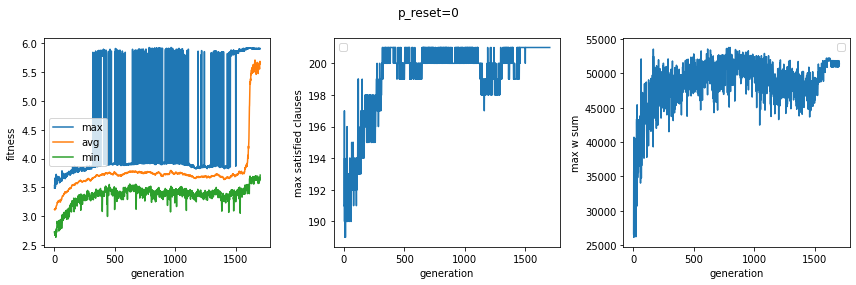

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(0.0, 0.0, 0, 0, 2.047691143073427, 2.047691143073427, 2.047691143073427, 1.0)

In [12]:

params = {'max_generations' : 2000, 'mutation_prob' : 0.001, 'crossover_prob' : 0.95, 'crossover' : 'uniform',\
            'create_graph': True, 'title': 'p_reset=0', 'pop_multiplifier' : 30, 'sel_size' : 0.18, 'fit_k': 3, 'fit_bonus': 2,\
           'mut_upg': True, 'fit_upg': False, 'fit_upg_add_k': 0, 'fit_upg_dec_k': 0, 'mut_p_greed' : 0.1, \
           'mut_p_reset': 0.00001}
run_sat_solver([(sat_tasks['N_50_201'])[16]], 1, sat_solver_genetic_upg, params)

params = {'max_generations' : 2000, 'mutation_prob' : 0.001, 'crossover_prob' : 0.95, 'crossover' : 'uniform',\
            'create_graph': True, 'title': 'p_reset=0.00001', 'pop_multiplifier' : 30, 'sel_size' : 0.18, 'fit_k': 3, 'fit_bonus': 2,\
           'mut_upg': False, 'fit_upg': False, 'fit_upg_add_k': 0, 'fit_upg_dec_k': 0, 'mut_p_greed' : 0.1, \
           'mut_p_reset': 0.00001}
run_sat_solver([(sat_tasks['N_50_201'])[16]], 1, sat_solver_genetic_upg, params)

params = {'max_generations' : 2000, 'mutation_prob' : 0.001, 'crossover_prob' : 0.95, 'crossover' : 'uniform',\
            'create_graph': True, 'title': 'p_reset=0.0001', 'pop_multiplifier' : 30, 'sel_size' : 0.18, 'fit_k': 3, 'fit_bonus': 2,\
           'mut_upg': False, 'fit_upg': False, 'fit_upg_add_k': 0, 'fit_upg_dec_k': 0, 'mut_p_greed' : 0.1, \
           'mut_p_reset': 0.00001}
run_sat_solver([(sat_tasks['N_50_201'])[16]], 1, sat_solver_genetic_upg, params)

params = {'max_generations' : 2000, 'mutation_prob' : 0.001, 'crossover_prob' : 0.95, 'crossover' : 'uniform',\
            'create_graph': True, 'title': 'p_reset=0.001', 'pop_multiplifier' : 30, 'sel_size' : 0.18, 'fit_k': 3, 'fit_bonus': 2,\
           'mut_upg': False, 'fit_upg': False, 'fit_upg_add_k': 0, 'fit_upg_dec_k': 0, 'mut_p_greed' : 0.1, \
           'mut_p_reset': 0.00001}
run_sat_solver([(sat_tasks['N_50_201'])[16]], 1, sat_solver_genetic_upg, params)




No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


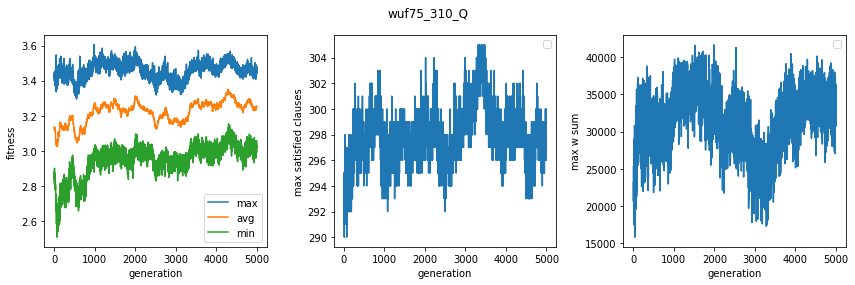

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


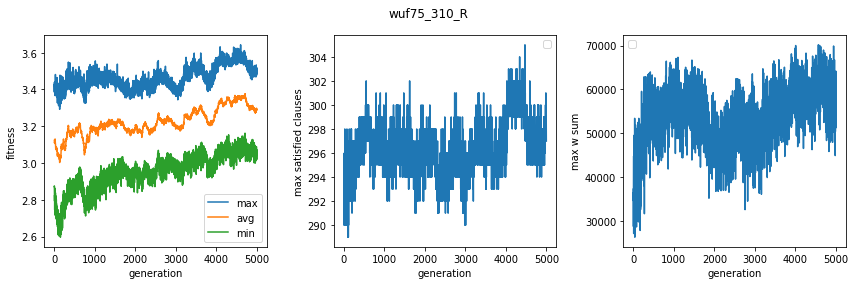

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


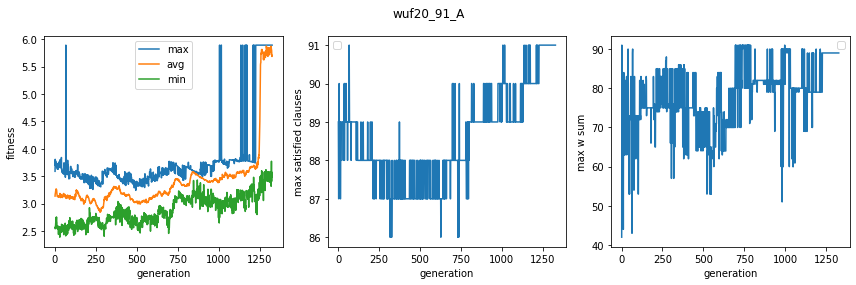

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


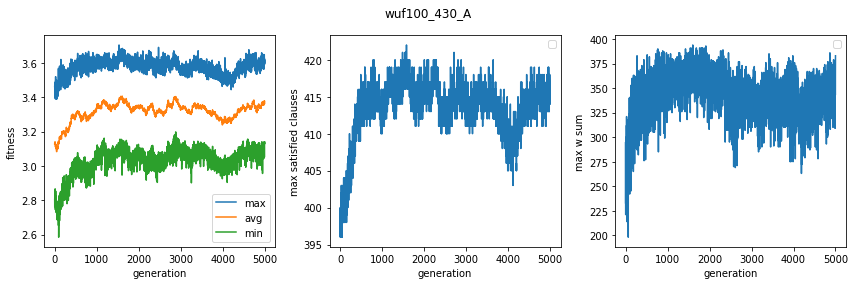

(0.0, 0.0, 0, 0, 100.0, 100, 100, 0.9813953488372092)

In [13]:
params = {'max_generations' : 5000, 'mutation_prob' : 0.001, 'crossover_prob' : 0.95, 'crossover' : 'uniform',\
  'create_graph': True, 'title': 'wuf75_310_N', 'pop_multiplifier' : 30, 'sel_size' : 0.18, 'fit_k': 3, 'fit_bonus': 2,\
  'mut_upg': True, 'fit_upg': True, 'fit_upg_add_k': 0.1, 'fit_upg_dec_k': 0.2, 'mut_p_greed' : 0.1, \
  'mut_p_reset': 0.00001}
run_sat_solver([(sat_tasks['N_75_310'])[32]], 1, sat_solver_genetic_upg, params)

params = {'max_generations' : 5000, 'mutation_prob' : 0.001, 'crossover_prob' : 0.95, 'crossover' : 'uniform',\
  'create_graph': True, 'title': 'wuf75_310_Q', 'pop_multiplifier' : 30, 'sel_size' : 0.18, 'fit_k': 3, 'fit_bonus': 2,\
  'mut_upg': True, 'fit_upg': True, 'fit_upg_add_k': 0.1, 'fit_upg_dec_k': 0.2, 'mut_p_greed' : 0.1, \
  'mut_p_reset': 0.00001}
run_sat_solver([(sat_tasks['Q_75_310'])[32]], 1, sat_solver_genetic_upg, params)

params = {'max_generations' : 5000, 'mutation_prob' : 0.001, 'crossover_prob' : 0.95, 'crossover' : 'uniform',\
  'create_graph': True, 'title': 'wuf75_310_R', 'pop_multiplifier' : 30, 'sel_size' : 0.18, 'fit_k': 3, 'fit_bonus': 2,\
  'mut_upg': True, 'fit_upg': True, 'fit_upg_add_k': 0.1, 'fit_upg_dec_k': 0.2, 'mut_p_greed' : 0.1, \
  'mut_p_reset': 0.00001}
run_sat_solver([(sat_tasks['R_75_310'])[32]], 1, sat_solver_genetic_upg, params)

params = {'max_generations' : 5000, 'mutation_prob' : 0.001, 'crossover_prob' : 0.95, 'crossover' : 'uniform',\
  'create_graph': True, 'title': 'wuf20_88_A', 'pop_multiplifier' : 30, 'sel_size' : 0.18, 'fit_k': 3, 'fit_bonus': 2,\
  'mut_upg': True, 'fit_upg': True, 'fit_upg_add_k': 0.1, 'fit_upg_dec_k': 0.2, 'mut_p_greed' : 0.1, \
  'mut_p_reset': 0.00001}
run_sat_solver([(sat_tasks['A_20_88'])[4]], 1, sat_solver_genetic_upg, params)

params = {'max_generations' : 5000, 'mutation_prob' : 0.001, 'crossover_prob' : 0.95, 'crossover' : 'uniform',\
  'create_graph': True, 'title': 'wuf20_91_A', 'pop_multiplifier' : 30, 'sel_size' : 0.18, 'fit_k': 3, 'fit_bonus': 2,\
  'mut_upg': True, 'fit_upg': True, 'fit_upg_add_k': 0.1, 'fit_upg_dec_k': 0.2, 'mut_p_greed' : 0.1, \
  'mut_p_reset': 0.00001}
run_sat_solver([(sat_tasks['A_20_91'])[4]], 1, sat_solver_genetic_upg, params)

params = {'max_generations' : 5000, 'mutation_prob' : 0.001, 'crossover_prob' : 0.95, 'crossover' : 'uniform',\
  'create_graph': True, 'title': 'wuf100_430_A', 'pop_multiplifier' : 30, 'sel_size' : 0.18, 'fit_k': 3, 'fit_bonus': 2,\
  'mut_upg': True, 'fit_upg': True, 'fit_upg_add_k': 0.1, 'fit_upg_dec_k': 0.2, 'mut_p_greed' : 0.1, \
  'mut_p_reset': 0.00001}
run_sat_solver([(sat_tasks['A_100_430'])[4]], 1, sat_solver_genetic_upg, params)